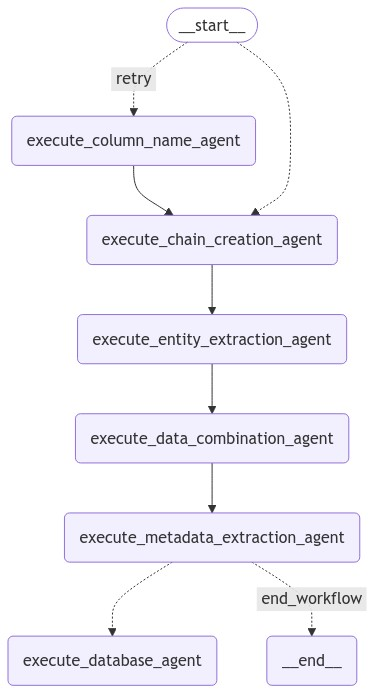

Final state: {'question': 'What are the types of agent memory?', 'column_name_str': 'Name:Name of the customer;PurchaseDate:Date of purchase of product', 'column_names': {'Name': '<Name of the customer>', 'PurchaseDate': '<Date of purchase of product>'}, 'chain': PromptTemplate(input_variables=['column_names', 'review'], input_types={}, partial_variables={}, template='You need to act as a Named Entity Recognizer.\n        Extract the following column names from the review text: {column_names}\n        \n        Review Text: "{review}"\n        \n        STRICTLY respond in JSON format like: {{"column_1": "<value 1>", ... }}\n        ')
| ChatOllama(model='llama3.2:3b-instruct-fp16', temperature=0.0)
| JsonOutputParser(), 'extracted_data': [{'Name': 'Alice', 'PurchaseDate': '2023-01-01'}, {'Name': 'Bob', 'PurchaseDate': '2023-01-02'}], 'merged_data':     Name PurchaseDate
0  Alice   2023-01-01
1    Bob   2023-01-02, 'db_engine': Engine(sqlite://), 'max_retries': 3, 'loop_step': 0, 'meta

In [1]:
import ollama
import langgraph
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
import sqlite3
import pandas as pd
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

# Define model for Ollama
local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0)

# Define shared graph state
class GraphState(TypedDict):
    question: str
    column_name_str: str
    column_names: dict
    chain: object
    extracted_data: List[dict]
    merged_data: pd.DataFrame
    db_engine: object
    max_retries: int
    loop_step: Annotated[int, operator.add]
    metadata: dict

### Define Agents
class ColumnNameAgent:
    def run(self, state):
        column_name_str = state["column_name_str"]
        column_names = {}
        for name in column_name_str.split(";"):
            col_name, desc = name.strip().split(':')
            column_names[col_name] = f"<{desc}>"
        state["column_names"] = column_names
        return state

class ChainCreationAgent:
    def run(self, state):
        column_names = state["column_names"]
        template = """You need to act as a Named Entity Recognizer.
        Extract the following column names from the review text: {column_names}
        
        Review Text: "{review}"
        
        STRICTLY respond in JSON format like: {{"column_1": "<value 1>", ... }}
        """
        output_parser = JsonOutputParser()
        prompt = PromptTemplate.from_template(template)
        chain = prompt | llm | output_parser
        state["chain"] = chain
        return state

class EntityExtractionAgent:
    def run(self, state):
        chain = state["chain"]
        review_texts = state["df2"]["ReviewText"].tolist()
        column_names = state["column_names"]
        extracted_data = []
        for review in review_texts:
            response = chain.invoke({"review": review, "column_names": column_names})
            extracted_data.append(response)
        state["extracted_data"] = extracted_data
        return state

class DataCombinationAgent:
    def run(self, state):
        df1 = state["df1"]
        extracted_data = state["extracted_data"]
        extracted_df = pd.DataFrame(extracted_data)
        merged_data = pd.merge(df1, extracted_df, left_on=list(state["column_names"].keys()), 
                               right_on=list(state["column_names"].keys()), how='left')
        merged_data.to_csv("merged_data.csv", index=False)
        state["merged_data"] = merged_data
        return state

class DatabaseAgent:
    def run(self, state):
        merged_data = state["merged_data"]
        connection = sqlite3.connect(":memory:", check_same_thread=False)
        merged_data.to_sql('my_table', connection, index=False, if_exists='replace')
        state["db_engine"] = create_engine(
            "sqlite://", creator=lambda: connection, poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        return state

class MetadataExtractionAgent:
    def run(self, state):
        df1 = state["df1"]
        df2 = state["df2"]
        metadata = {
            "df1": {
                "columns": df1.columns.tolist(),
                "dtypes": df1.dtypes.apply(str).to_dict(),
                "num_rows": len(df1),
                "missing_values": df1.isnull().sum().to_dict(),
                "statistical_summary": df1.describe().to_dict(),
                "outliers": df1.apply(lambda x: x[(x - x.mean()).abs() > 3 * x.std()].tolist() if x.dtype != 'O' else []).to_dict()
            },
            "df2": {
                "columns": df2.columns.tolist(),
                "dtypes": df2.dtypes.apply(str).to_dict(),
                "num_rows": len(df2),
                "missing_values": df2.isnull().sum().to_dict(),
                "statistical_summary": df2.describe().to_dict(),
                "outliers": df2.apply(lambda x: x[(x - x.mean()).abs() > 3 * x.std()].tolist() if x.dtype != 'O' else []).to_dict()
            },
            "data_quality": {
                "df1": {
                    "completeness": (1 - df1.isnull().mean()).to_dict(),
                    "uniqueness": df1.nunique().to_dict(),
                    "consistency": "N/A"  # Placeholder, implement custom logic if needed
                },
                "df2": {
                    "completeness": (1 - df2.isnull().mean()).to_dict(),
                    "uniqueness": df2.nunique().to_dict(),
                    "consistency": "N/A"  # Placeholder, implement custom logic if needed
                }
            }
        }
        state["metadata"] = metadata
        return state

### Define Graph Nodes for Workflow Execution
def execute_column_name_agent(state):
    return ColumnNameAgent().run(state)

def execute_chain_creation_agent(state):
    return ChainCreationAgent().run(state)

def execute_entity_extraction_agent(state):
    return EntityExtractionAgent().run(state)

def execute_data_combination_agent(state):
    return DataCombinationAgent().run(state)

def execute_database_agent(state):
    return DatabaseAgent().run(state)

def execute_metadata_extraction_agent(state):
    return MetadataExtractionAgent().run(state)

# Decision function to proceed based on step completion
def decide_next_step(state):
    if state["loop_step"] < state["max_retries"]:
        return "execute_database_agent"
    else:
        return END

def decide_entry_point(state):
    if "column_name_str" in state and state["column_name_str"]:
        return "execute_chain_creation_agent"
    else:
        return "retry"

### Create Workflow Graph with Conditional Entry Points and Edges
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("execute_column_name_agent", execute_column_name_agent)
workflow.add_node("execute_chain_creation_agent", execute_chain_creation_agent)
workflow.add_node("execute_entity_extraction_agent", execute_entity_extraction_agent)
workflow.add_node("execute_data_combination_agent", execute_data_combination_agent)
workflow.add_node("execute_database_agent", execute_database_agent)
workflow.add_node("execute_metadata_extraction_agent", execute_metadata_extraction_agent)

# Define the entry point and edges
workflow.set_conditional_entry_point(
    decide_entry_point,
    {
        "execute_chain_creation_agent": "execute_chain_creation_agent",
        "retry": "execute_column_name_agent",
    },
)

workflow.add_edge("execute_column_name_agent", "execute_chain_creation_agent")
workflow.add_edge("execute_chain_creation_agent", "execute_entity_extraction_agent")
workflow.add_edge("execute_entity_extraction_agent", "execute_data_combination_agent")
workflow.add_edge("execute_data_combination_agent", "execute_metadata_extraction_agent")
workflow.add_conditional_edges(
    "execute_metadata_extraction_agent",
    decide_next_step,
    {
        "execute_database_agent": "execute_database_agent",
        "end_workflow": END,
    },
)

# Compile and display the graph
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# Process function to execute workflow step by step
def process_workflow(state):
    next_node = "execute_column_name_agent"
    while next_node != END:
        if next_node == "execute_column_name_agent":
            state = execute_column_name_agent(state)
            next_node = "execute_chain_creation_agent"
        elif next_node == "execute_chain_creation_agent":
            state = execute_chain_creation_agent(state)
            next_node = "execute_entity_extraction_agent"
        elif next_node == "execute_entity_extraction_agent":
            state = execute_entity_extraction_agent(state)
            next_node = "execute_data_combination_agent"
        elif next_node == "execute_data_combination_agent":
            state = execute_data_combination_agent(state)
            next_node = "execute_metadata_extraction_agent"
        elif next_node == "execute_metadata_extraction_agent":
            state = execute_metadata_extraction_agent(state)
            next_node = decide_next_step(state)
        elif next_node == "execute_database_agent":
            state = execute_database_agent(state)
            next_node = END
        else:
            raise ValueError("Unknown next node: {}".format(next_node))
    return state

# Initialize the state and run the workflow
initial_state = GraphState(
    question="What are the types of agent memory?",
    column_name_str="Name:Name of the customer;PurchaseDate:Date of purchase of product",
    column_names={},
    chain=None,
    extracted_data=[],
    merged_data=pd.DataFrame(),
    db_engine=None,
    max_retries=3,
    loop_step=0,
    metadata={}
)

# Example data for df1 and df2 (replace these with actual data)
initial_state["df1"] = pd.DataFrame({
    'Name': ['Alice', 'Bob'],
    'PurchaseDate': ['2023-01-01', '2023-01-02']
})

initial_state["df2"] = pd.DataFrame({
    'ReviewText': ['Alice bought a product on 2023-01-01.', 'Bob bought a product on 2023-01-02.']
})

# Run the workflow step by step
final_state = process_workflow(initial_state)

# Output the result
print("Final state:", final_state)
print("Database engine:", final_state["db_engine"])
print("Metadata:", final_state["metadata"])
